# A/B‑Test Analysis – Dating App Premium Pricing Experiment

Author: *your name here*
Date: 1 August 2025

## 0. Contents  
1. [Data Loading](#data-loading)  
2. [Data Quality & Balance](#data-quality)  
3. [Metric Definition](#metrics)  
4. [Statistical Tests](#tests)  
5. [Segment Analysis](#segments)  
6. [Conclusions](#conclusions)

## 1. Data Loading <a id='data-loading'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Helper for robust CSV reading
def read_csv_robust(path):
    attempts = [
        {'encoding':'utf-8', 'sep':','},
        {'encoding':'utf-8', 'sep':';'},
        {'encoding':'utf-8-sig', 'sep':','},
        {'encoding':'utf-8-sig', 'sep':';'},
        {'encoding':'cp1251', 'sep':','},
        {'encoding':'cp1251', 'sep':';'},
    ]
    for opts in attempts:
        try:
            return pd.read_csv(path, **opts)
        except Exception:
            continue
    raise ValueError(f'Cannot read {path}')

file_paths = {
    'users_control_1': '/Users/aleksey/Downloads/Проект_3_users_control_1.csv',
    'users_control_2': '/Users/aleksey/Downloads/Проект_3_users_control_2.csv',
    'users_test':      '/Users/aleksey/Downloads/Проект_3_users_test.csv',
    'transactions_control_1': '/Users/aleksey/Downloads/Проект_3_transactions_control_1.csv',
    'transactions_control_2': '/Users/aleksey/Downloads/Проект_3_transactions_control_2.csv',
    'transactions_test':      '/Users/aleksey/Downloads/Проект_3_transactions_test.csv',
}

data = {k: read_csv_robust(p) for k,p in file_paths.items()}

for k in ['transactions_control_1','transactions_control_2','transactions_test']:
    # ensure ;‑separated transactions are parsed correctly (if not already)
    if data[k].shape[1]==1:
        data[k] = pd.read_csv(file_paths[k], sep=';', encoding='utf-8')

print({k: data[k].shape for k in data})


{'users_control_1': (4340, 13), 'users_control_2': (4264, 13), 'users_test': (4308, 13), 'transactions_control_1': (1007, 8), 'transactions_control_2': (328, 8), 'transactions_test': (273, 8)}


## 2. Data Quality & Balance <a id='data-quality'></a>

In [2]:
# Basic demographics summary
def summarise_users(df):
    return pd.Series({
        'n_users': len(df),
        'age_mean': df['age'].mean(),
        'age_median': df['age'].median(),
        'male_frac': (df['gender']==1).mean(),
        'female_frac': (df['gender']==0).mean(),
        'countries': df['country'].nunique()
    })

demo = pd.concat({
    'control_1': summarise_users(data['users_control_1']),
    'control_2': summarise_users(data['users_control_2']),
    'test':      summarise_users(data['users_test'])
}, axis=1).T
demo


,n_users,age_mean,age_median,male_frac,female_frac,countries
control_1,4340.0,32.095392,30.0,0.958065,0.041935,40.0
control_2,4264.0,32.046201,30.0,0.954268,0.045732,45.0
test,4308.0,31.889276,30.0,0.953110,0.046890,51.0


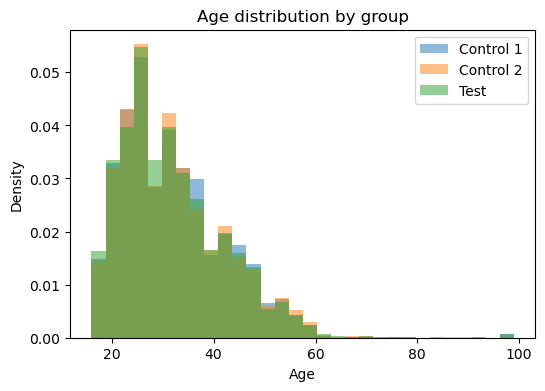

In [3]:
# Age distribution plot
plt.figure(figsize=(6,4))
for label, df in [('Control 1', data['users_control_1']),
                  ('Control 2', data['users_control_2']),
                  ('Test',       data['users_test'])]:
    plt.hist(df['age'], bins=30, alpha=0.5, label=label, density=True)
plt.legend()
plt.title('Age distribution by group')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()


## 3. Metric Definition <a id='metrics'></a>
* **Primary metric:** conversion to paid Premium (`premium_no_trial`).
* **Secondary:** ARPU (revenue per user) from all products.
* **Unit of analysis:** user.

In [4]:
# Helper to compute metrics
def compute_metrics(users_df, trans_df):
    premium = trans_df.loc[trans_df['product_type']=='premium_no_trial','uid'].unique()
    rev_per_user = trans_df.groupby('uid')['revenue'].sum()
    users_df = users_df.copy()
    users_df['payer'] = users_df['uid'].isin(premium)
    users_df['revenue'] = users_df['uid'].map(rev_per_user).fillna(0)
    return pd.Series({
        'users': len(users_df),
        'premium_payers': users_df['payer'].sum(),
        'conversion': users_df['payer'].mean(),
        'total_revenue': users_df['revenue'].sum(),
        'arpu': users_df['revenue'].mean()
    })

metrics = pd.concat({
    'control_1': compute_metrics(data['users_control_1'], data['transactions_control_1']),
    'control_2': compute_metrics(data['users_control_2'], data['transactions_control_2']),
    'test':      compute_metrics(data['users_test'],      data['transactions_test'])
}, axis=1).T

# Combine controls
control_combined_users = pd.concat([data['users_control_1'], data['users_control_2']])
control_combined_trans = pd.concat([data['transactions_control_1'], data['transactions_control_2']])
metrics.loc['control_combined'] = compute_metrics(control_combined_users, control_combined_trans)

metrics


,users,premium_payers,conversion,total_revenue,arpu
control_1,4340.0,99.0,0.022811,2612311.0,601.914977
control_2,4264.0,102.0,0.023921,1920438.0,450.384146
test,4308.0,67.0,0.015552,2344901.0,544.313138
control_combined,8604.0,201.0,0.023361,4532749.0,526.818805


## 4. Statistical Tests <a id='tests'></a>

In [5]:
# Conversion z‑test (combined control vs test)
success = [metrics.loc['control_combined','premium_payers'],
           metrics.loc['test','premium_payers']]
nobs = [metrics.loc['control_combined','users'], metrics.loc['test','users']]
z_stat, p_val = proportions_ztest(count=success, nobs=nobs, alternative='two-sided')
print(f'Conversion z‑test: z = {z_stat:.3f}, p = {p_val:.4f}')

# ARPU Welch t‑test
control_rev = control_combined_trans.groupby('uid')['revenue'].sum()
test_rev    = data['transactions_test'].groupby('uid')['revenue'].sum()

control_rev_full = pd.Series(0, index=control_combined_users['uid'])
control_rev_full.update(control_rev)
test_rev_full = pd.Series(0, index=data['users_test']['uid'])
test_rev_full.update(test_rev)

t_stat, p_val_arpu = ttest_ind(control_rev_full, test_rev_full, equal_var=False)
print(f'ARPU Welch t‑test: t = {t_stat:.3f}, p = {p_val_arpu:.4f}')


Conversion z‑test: z = 2.935, p = 0.0033
ARPU Welch t‑test: t = -0.186, p = 0.8523


## 5. Segment Analysis (by Country) <a id='segments'></a>

In [6]:
def conv_by_country(users_df, trans_df):
    premium = trans_df.loc[trans_df['product_type']=='premium_no_trial','uid'].unique()
    users_df = users_df.copy()
    users_df['payer'] = users_df['uid'].isin(premium)
    g = users_df.groupby('country')['payer'].agg(['count','sum']).rename(columns={'count':'users','sum':'payers'})
    g['conversion'] = g['payers']/g['users']
    return g

ctrl_country = conv_by_country(control_combined_users, control_combined_trans)
test_country = conv_by_country(data['users_test'], data['transactions_test'])

cmp = ctrl_country.join(test_country, lsuffix='_ctrl', rsuffix='_test', how='inner')
cmp = cmp[(cmp['users_ctrl']>=30)&(cmp['users_test']>=30)]
cmp['lift'] = cmp['conversion_test']/cmp['conversion_ctrl'] - 1
cmp_sorted = cmp.sort_values('lift')
cmp_sorted.head()


,users_ctrl,payers_ctrl,conversion_ctrl,users_test,payers_test,conversion_test,lift
country,,,,,,,
Portugal,200,6,0.030000,91,0,0.000000,-1.000000
Switzerland,77,4,0.051948,35,0,0.000000,-1.000000
Israel,187,12,0.064171,106,2,0.018868,-0.705975
Belgium,198,6,0.030303,92,1,0.010870,-0.641304
France,746,20,0.026810,359,4,0.011142,-0.584401


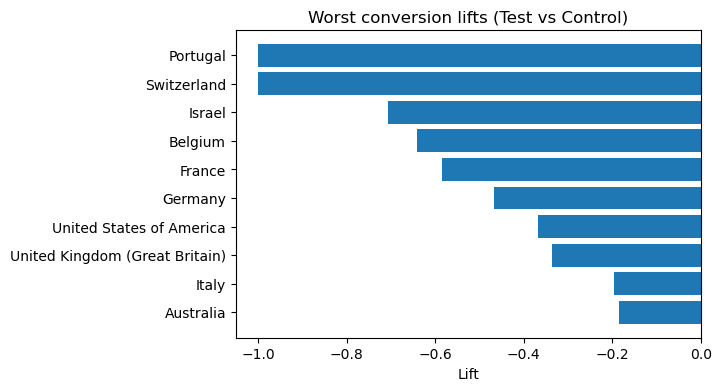

In [7]:
# Plot top‑10 negative lifts
top_neg = cmp_sorted.head(10)
plt.figure(figsize=(6,4))
plt.barh(top_neg.index, top_neg['lift'])
plt.title('Worst conversion lifts (Test vs Control)')
plt.xlabel('Lift')
plt.gca().invert_yaxis()
plt.show()


## 6. Conclusions <a id='conclusions'></a>
* **Конверсия** упала с 2.34 % до 1.56 % (p ≈ 0.003) — статистически значимый негативный эффект.
* **ARPU** номинально +3.3 %, но p ≈ 0.85 → отличий нет.
* Большинство крупных стран демонстрируют отрицательный lift; единичный позитив (ОАЭ) недостаточен.

**Решение:** откатить изменение и протестировать цену и платёжные системы раздельно.